In [ ]:
!pip install complexPyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from torchvision.utils import make_grid
import os
import random
import numpy as np
import pandas as pd
import pickle
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, jaccard_similarity_score
from google.colab import drive
from complexPyTorch.complexLayers import ComplexBatchNorm2d, ComplexConv2d, ComplexLinear
from complexPyTorch.complexFunctions import complex_relu, complex_max_pool2d

In [ ]:
!nvidia-smi

Wed Jun 23 20:47:41 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    38W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
training_data = pickle.load(open('/content/drive/My Drive/trainingData.pickle', 'rb'))

In [ ]:
Xt = []
yt = []
features = None
labels = None
label = []

In [ ]:
for features,labels in training_data:
  Xt.append(features)
  yt.append(labels)

In [ ]:
a = np.array(Xt)
b = np.array(yt)
type(a)

numpy.ndarray

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(a, b, test_size=0.25, shuffle=True)  # 70% training, 30% testing

In [ ]:
print("Xtrain data shape",X_train.shape)
print("YTrain data shape",y_train.shape)

Xtrain data shape (2298, 512, 512, 3)
YTrain data shape (2298,)


In [ ]:
#t = transforms.ToTensor()
#te = t(X_train[1])
#test = torch.fft.ifftn(te)
#test

(<matplotlib.axes._subplots.AxesSubplot at 0x7f56fb082690>,
 <matplotlib.image.AxesImage at 0x7f56fb03d910>)

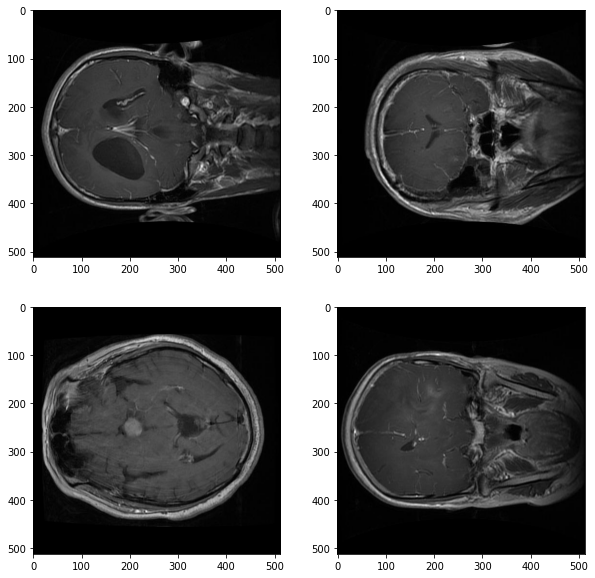

In [ ]:
# visualizing images
i = 0
plt.figure(figsize=(10,10))
plt.subplot(221), plt.imshow(X_train[i], cmap='gray')
plt.subplot(222), plt.imshow(X_train[i+30], cmap='gray')
plt.subplot(223), plt.imshow(X_train[i+50], cmap='gray')
plt.subplot(224), plt.imshow(X_train[i+100], cmap='gray')

In [ ]:
class BrainTumorDataset(Dataset):
  def __init__(self, images, labels):
    # images
    self.X = images
    # labels
    self.y = labels
    #converts numpy array to tensor
    self.transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
  def __len__(self):
    # return length of image samples
    return len(self.X)

  def __getitem__(self, idx):
    # perform transformations on one instance of X
    # numpy array as a tensor
    d = self.transform(self.X[idx])
    data = torch.fft.ifftn(d)
    
    # store the transformed images in a list
    new_batch = [data]

    # one-hot encode the labels
    labels = torch.zeros(4, dtype=torch.float32)
    labels[int(self.y[idx])] = 1.0
    #labels = self.y[idx]
    new_labels = [labels]
    # 8 augmented images and corresponding labels per sample will be returned
    return (torch.stack(new_labels), torch.stack(new_batch))

In [ ]:
Xt = None
yt = None
features = None
labels = None
label = None
training_data = None
a = None
b = None

In [ ]:
train_set = BrainTumorDataset(X_train, y_train)
#valid_set = BrainTumorDataset(X_valid, y_valid)
test_set = BrainTumorDataset(X_test, y_test)

In [ ]:
print(f"Number of training samples: {len(X_train)}")
#print(f"Number of validation samples: {len(X_valid)}")
print(f"Number of testing samples: {len(X_test)}")

Number of training samples: 2298
Number of testing samples: 766


In [ ]:
train_gen = DataLoader(train_set, batch_size=4, shuffle=True, pin_memory=True, num_workers=8)
#valid_gen = DataLoader(valid_set, batch_size=4, shuffle=True, pin_memory=True, num_workers=8)
test_gen = DataLoader(test_set, batch_size=4, shuffle=True, pin_memory=True, num_workers=8)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
class ComplexCnn(nn.Module):
    
    def __init__(self):
        super(ComplexCnn, self).__init__()
        self.conv1 = ComplexConv2d(3,64,5)
        self.bn  = ComplexBatchNorm2d(64)
        self.conv2 = ComplexConv2d(64, 16, 5)
        self.fc1 = ComplexLinear(16*125*125, 1000)
        self.fc2 = ComplexLinear(1000, 100)
             
    def forward(self,x):
        x = self.conv1(x)
        x = complex_relu(x)
        x = complex_max_pool2d(x, 2, 2)
        x = self.bn(x)
        x = self.conv2(x)
        x = complex_relu(x)
        x = complex_max_pool2d(x, 2, 2)
        x = x.view(-1,16*125*125)
        x = self.fc1(x)
        x = complex_relu(x)
        x = self.fc2(x)
        x = x.abs()
        x =  F.log_softmax(x, dim=1)
        return x

In [ ]:
device = device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = xm.xla_device()
# defining the model
model = ComplexCnn().to(device)  
print(model)

ComplexCnn(
  (conv1): ComplexConv2d(
    (conv_r): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
    (conv_i): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
  )
  (bn): ComplexBatchNorm2d()
  (conv2): ComplexConv2d(
    (conv_r): Conv2d(64, 16, kernel_size=(5, 5), stride=(1, 1))
    (conv_i): Conv2d(64, 16, kernel_size=(5, 5), stride=(1, 1))
  )
  (fc1): ComplexLinear(
    (fc_r): Linear(in_features=250000, out_features=1000, bias=True)
    (fc_i): Linear(in_features=250000, out_features=1000, bias=True)
  )
  (fc2): ComplexLinear(
    (fc_r): Linear(in_features=1000, out_features=100, bias=True)
    (fc_i): Linear(in_features=1000, out_features=100, bias=True)
  )
)


In [ ]:
# loss function
# if GPU is available set loss function to use GPU
criterion = nn.CrossEntropyLoss().to(device)

# optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=3e-4, momentum=0.9)

# number of training iterations
epochs = 30

# empty lists to store losses and accuracies
train_losses = []
test_losses = []
train_correct = []
test_correct = []

In [ ]:
def save_checkpoint(state, is_best, filename='/content/drive/My Drive/bt_resnet50_ckpt_v2.pth.tar'):
    torch.save(state, filename)

In [ ]:
# set training start time
start_time = time.time()

# set best_prec loss value as 2 for checkpoint threshold
best_prec1 = 2

# empty batch variables
b = None
train_b = None
test_b = None

# start training
for i in range(epochs):
    # empty training correct and test correct counter as 0 during every iteration
    trn_corr = 0
    tst_corr = 0
    
    # set epoch's starting time
    e_start = time.time()
    
    # train in batches
    for b, (y, X) in enumerate(train_set):
        # set label as cuda if device is cuda
        X, y = X.to(device), y.to(device)
        # forward pass image sample
        y_pred = model(X.view(-1, 3, 512, 512))
        # calculate loss
        loss = criterion(y_pred.float(), torch.argmax(y.view(1,4), dim=1).long())

        # get argmax of predicted tensor, which is our label
        predicted = torch.argmax(y_pred, dim=1).data
        # if predicted label is correct as true label, calculate the sum for samples
        batch_corr = (predicted == torch.argmax(y.view(1, 4), dim=1)).sum()
        # increment train correct with correcly predicted labels per batch
        trn_corr += batch_corr
        
        # set optimizer gradients to zero
        optimizer.zero_grad()
        # back propagate with loss
        loss.backward()
        # perform optimizer step
        optimizer.step()

    # set epoch's end time
    e_end = time.time()
    # print training metrics
    print(f'Epoch {(i+1)} Batch {(b+1)*1}\nAccuracy: {trn_corr.item()*100/(len(train_set)):2.2f} %  Loss: {loss.item():2.4f}  Duration: {((e_end-e_start)/60):.2f} minutes') # 4 images per batch * 8 augmentations per image * batch length

    # some metrics storage for visualization
    train_b = b
    train_losses.append(loss)
    train_correct.append(trn_corr)

    X, y = None, None

    # validate using validation generator
    # do not perform any gradient updates while validation
    with torch.no_grad():
        for b, (y, X) in enumerate(test_set):
            # set label as cuda if device is cuda
            X, y = X.to(device), y.to(device)
            #print(y.shape)
            # forward pass image
            y_val = model(X.view(-1, 3, 512, 512))

            # get argmax of predicted tensor, which is our label
            predicted = torch.argmax(y_val, dim=1).data

            # increment test correct with correcly predicted labels per batch
            tst_corr += (predicted == torch.argmax(y.view(1, 4), dim=1)).sum()

    # get loss of validation set
    loss = criterion(y_val.float(), torch.argmax(y.view(1, 4), dim=1).long())
    # print validation metrics
    print(f'Validation Accuracy {tst_corr.item()*100/(len(test_set)):2.2f} Validation Loss: {loss.item():2.4f}\n')

    # if current validation loss is less than previous iteration's validatin loss create and save a checkpoint
    is_best = loss < best_prec1
    best_prec1 = min(loss, best_prec1)
    save_checkpoint({
            'epoch': i + 1,
            'state_dict': model.state_dict(),
            'best_prec1': best_prec1,
        }, is_best)

    # some metrics storage for visualization
    test_b  = b
    test_losses.append(loss)
    test_correct.append(tst_corr)

# set total training's end time
end_time = time.time() - start_time    

# print training summary
print("\nTraining Duration {:.2f} minutes".format(end_time/60))
print("GPU memory used : {} kb".format(torch.cuda.memory_allocated()))
print("GPU memory cached : {} kb".format(torch.cuda.memory_cached()))

Epoch 1 Batch 2298
Accuracy: 65.36 %  Loss: 0.2204  Duration: 5.93 minutes
Validation Accuracy 64.62 Validation Loss: 0.2485

Epoch 2 Batch 2298
Accuracy: 75.81 %  Loss: 0.1208  Duration: 5.93 minutes
Validation Accuracy 66.71 Validation Loss: 0.2276

Epoch 3 Batch 2298
Accuracy: 81.68 %  Loss: 0.3312  Duration: 5.93 minutes
Validation Accuracy 72.72 Validation Loss: 0.2100

Epoch 4 Batch 2298
Accuracy: 86.47 %  Loss: 0.0028  Duration: 5.93 minutes
Validation Accuracy 80.55 Validation Loss: 0.1699

Epoch 5 Batch 2298
Accuracy: 91.64 %  Loss: 0.0002  Duration: 5.93 minutes
Validation Accuracy 82.64 Validation Loss: 0.1133

Epoch 6 Batch 2298
Accuracy: 94.30 %  Loss: 0.0011  Duration: 5.93 minutes
Validation Accuracy 81.98 Validation Loss: 0.0324

Epoch 7 Batch 2298
Accuracy: 94.95 %  Loss: 0.0000  Duration: 5.93 minutes
Validation Accuracy 74.93 Validation Loss: 0.0152

Epoch 8 Batch 2298
Accuracy: 96.21 %  Loss: 0.0001  Duration: 5.93 minutes
Validation Accuracy 84.99 Validation Loss: 

/usr/local/lib/python3.7/dist-packages/torch/cuda/memory.py:375: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)


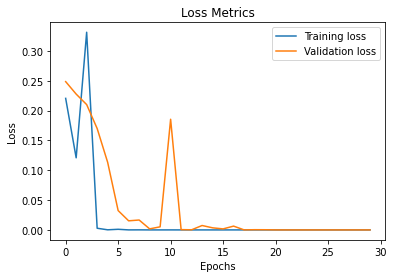

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.title('Loss Metrics')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

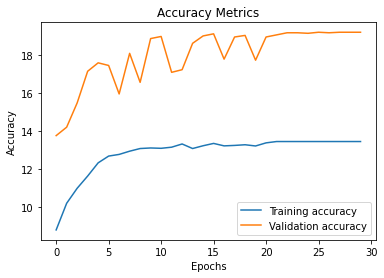

In [ ]:
plt.plot([t/171 for t in train_correct], label='Training accuracy')
plt.plot([t/36 for t in test_correct], label='Validation accuracy')
plt.title('Accuracy Metrics')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()